# Dependencies

In [1]:
import numpy as np
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from scipy.interpolate import PchipInterpolator

from tqdm import tqdm

# Working on...

In [11]:
# Specify the directory path
dir_path = "../files/data/"

# Get folder names
master_folders = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]

print(master_folders)

['BH_SINGLE', 'FA700021D0002-23F0143', 'FA700021D0002-22F0214']


In [12]:
master_folder = master_folders[2]

# Specify the directory path
dir_path = "../files/data/{}".format(master_folder)

# Get folder names
folders = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]

print(folders)

['20230228_SingleCracksatCountersunkHoles', '20230926_CountersunkHoles_CS-2023-bt0d05']


# .DAT to .csv

In [7]:
def process_file(file_info):
    input_file_path, output_file_path = file_info
    
    rows = []
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        W_R = None
        a_c, a_t, r_t, b_t = None, None, None, None
        crack = False

        for i, line in enumerate(lines):
            values = line.strip().split()
            if not values:
                continue

            if values[0] == "Results":
                W_R = float(values[4][:-1])

            elif values[0] == "ndom":
                crack = False
                next_values = lines[i + 1].strip().split()
                a_c, a_t, r_t, b_t = map(float, next_values[1:5])

            elif values[0] == "crack":
                crack = True

            elif values[0].isdigit() and crack:
                row = [W_R, a_c, a_t, r_t, b_t] + list(map(float, values[6:10]))
                rows.append(row)

    df = pd.DataFrame(rows, columns=['W/R', 'a/c', 'a/t', 'r/t', 'b/t', 'phi', 'K-T', 'K-B', 'K-P'])
    df.to_csv(output_file_path, index=False)

tasks = []

for folder in folders:
    dir_path = os.path.join("../files/data", master_folder, folder)
    files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

    for file_name in files:
        input_file_path = os.path.join(dir_path, file_name)
        output_file_path = os.path.join(dir_path, f"{file_name[:-4]}.csv")
        tasks.append((input_file_path, output_file_path))

# Process files in parallel
with ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(process_file, tasks), total=len(tasks), desc="Processing Files"))
    # executor.map(process_file, tasks)


Processing Files:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Files: 100%|██████████| 11/11 [01:19<00:00,  7.25s/it]


# One .csv for each b/t

In [8]:
for folder in folders:
    # Specify the directory path
    dir_path = "../files/data/{}/{}".format(master_folder, folder)

    # Get all .csv files
    csv_files = [f for f in os.listdir(dir_path) if f.endswith(".csv")]

    print(csv_files)

    df = pd.read_csv("../files/data/{}/{}/{}".format(master_folder, folder, csv_files[0]))
    # df = df.drop(columns=["b/t"])
    df = df.drop(df[df['phi'] == 0].index)
    df = df.drop(df[df['K-T'] == 0].index)
    df = df.drop(df[df['K-B'] == 0].index)
    df = df.drop(df[df['K-P'] == 0].index)
    df.dropna(inplace=True)

    for index in csv_files[1:]:
        df_ = pd.read_csv("../files/data/{}/{}/{}".format(master_folder, folder, index))
        # df_ = df_.drop(columns=["b/t"])
        df_ = df_.drop(df_[df_['phi'] == 0].index)
        df_ = df_.drop(df_[df_['K-T'] == 0].index)
        df_ = df_.drop(df_[df_['K-B'] == 0].index)
        df_ = df_.drop(df_[df_['K-P'] == 0].index)
        df_.dropna(inplace=True)
        df = pd.concat([df, df_], axis=0, ignore_index=True)

    df.to_csv("../files/data/{}/{}.csv".format(master_folder, folder), index=False)

['CASE12-Rt0d5-CS-KandS-DBASE.csv', 'CASE9-Rt0d333-CS-KandS-DBASE.csv', 'CASE7-Rt0d2-CS-KandS-DBASE.csv', 'CASE22-Rt2d0-CS-KandS-DBASE.csv', 'CASE25-Rt3d0-CS-KandS-DBASE.csv', 'CASE20-Rt1d5-CS-KandS-DBASE.csv', 'CASE27-Rt5d0-CS-KandS-DBASE.csv', 'CASE17-Rt1d0-CS-KandS-DBASE.csv']
['CS_Rt0d667-bt0d05-KandS-DBASE.csv', 'CS_Rt0d5-bt0d05-KandS-DBASE.csv', 'CS-Rt0d25-bt0d05-KandS-DBASE.csv']


# Viz each .csv

In [13]:
# Specify the directory path
dir_path = "../files/data/{}".format(master_folder)

# Get all .csv files
csv_files = [f for f in os.listdir(dir_path) if f.endswith(".csv")]

print(csv_files)

['20230228_SingleCracksatCountersunkHoles.csv', '20230926_CountersunkHoles_CS-2023-bt0d05.csv']


Working On: 20230228_SingleCracksatCountersunkHoles.csv
Different combinations:  36813

Different W/r values:  [ 2.4  2.6  2.8  3.2  3.6  4.   4.6  5.2  5.8  6.4  7.   8.   9.  10.
 12.  16.  20.  30.  40. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.7333
  0.75    0.8     0.8186  0.9     1.      1.1111  1.2255  1.25    1.333
  1.5     2.      3.      6.     10.    ]
Different a/t values:  [ 0.1     0.2     0.3     0.4     0.5     0.6     0.7     0.7001  0.7999
  0.8     0.8001  0.8999  0.9     0.9001  0.9499  0.95    0.9501  1.075
  1.1     1.125   1.25    1.275   1.3999  1.4     1.4001  1.7999  1.8
  1.8001  2.3998  2.3999  2.4     2.4001  2.4002  3.1999  3.2     3.2001
  3.2002  4.4996  4.4998  4.4999  4.5     4.5001  4.5002  6.4997  6.4998
  6.4999  6.5     6.5001  6.5003 10.     10.0003 14.9989 14.9993 14.9994
 14.9995 14.9997 14.9998 14.9999 15.     15.0001 15.0002 15.0003 15.0004
 15.0006 15.0007 15.0009]
Different r/t values:  [0.

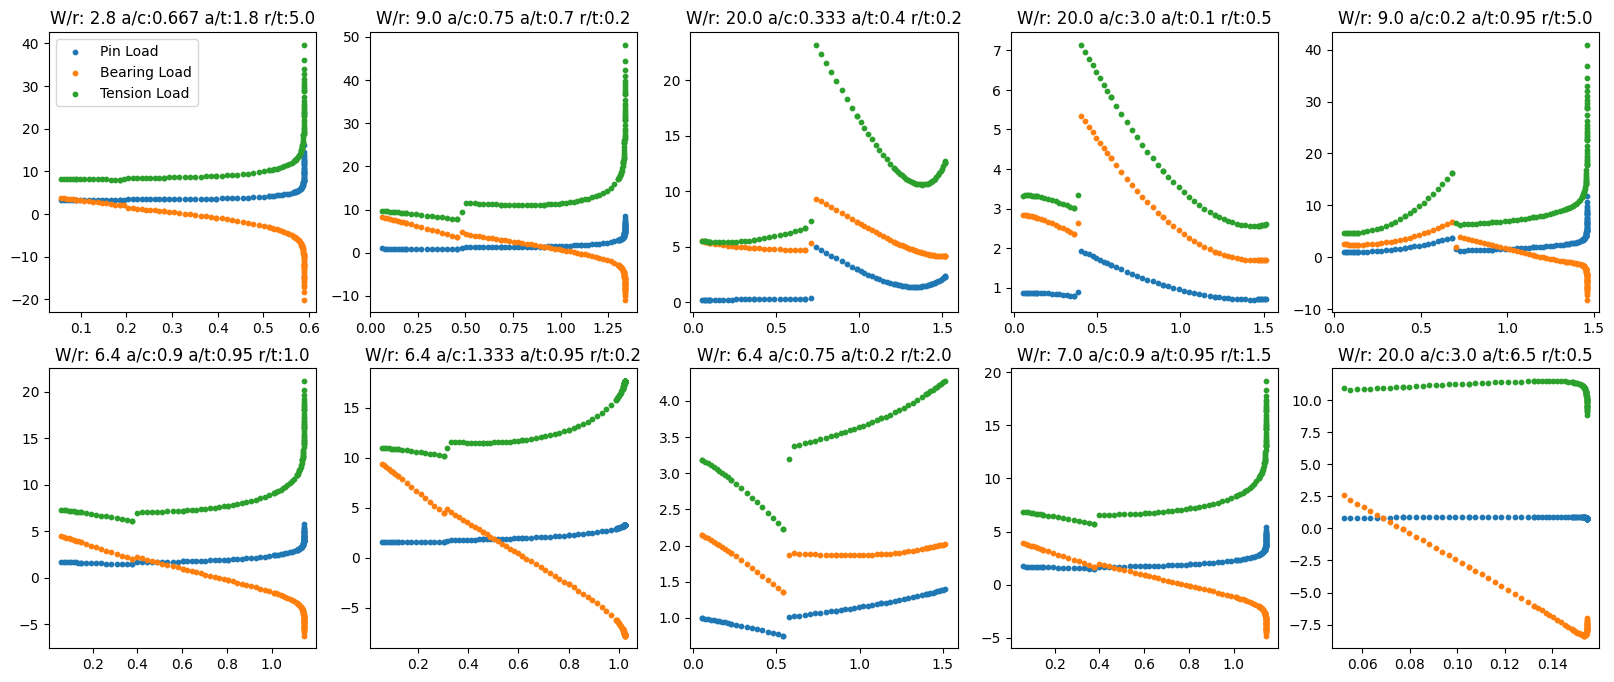

Working On: 20230926_CountersunkHoles_CS-2023-bt0d05.csv
Different combinations:  14563

Different W/r values:  [   2.997    3.147    3.297    3.447    3.664    3.672    3.864    3.897
    4.064    4.197    4.264    4.564    4.571    4.864    4.946    5.264
    5.321    5.696    5.764    5.929    6.264    6.329    6.446    6.729
    6.764    7.129    7.195    7.264    7.529    8.129    8.264    8.694
    8.729    9.264    9.529   10.529   11.264   11.529   11.693   12.529
   13.529   15.264   15.529   16.191   17.529   20.688   21.264   21.529
   26.685   27.264   29.529   32.682   35.264   40.179   41.529   43.264
   47.675   53.264   53.529   62.667   63.264   69.529   77.66    83.264
   85.529   92.652  103.264  105.529  122.637  123.264  125.529  152.622
  163.264  165.529  203.264  205.529  227.585  245.529  302.547  303.264
  325.529  403.264  405.529  602.398  605.529  803.264  805.529 1605.529]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.6

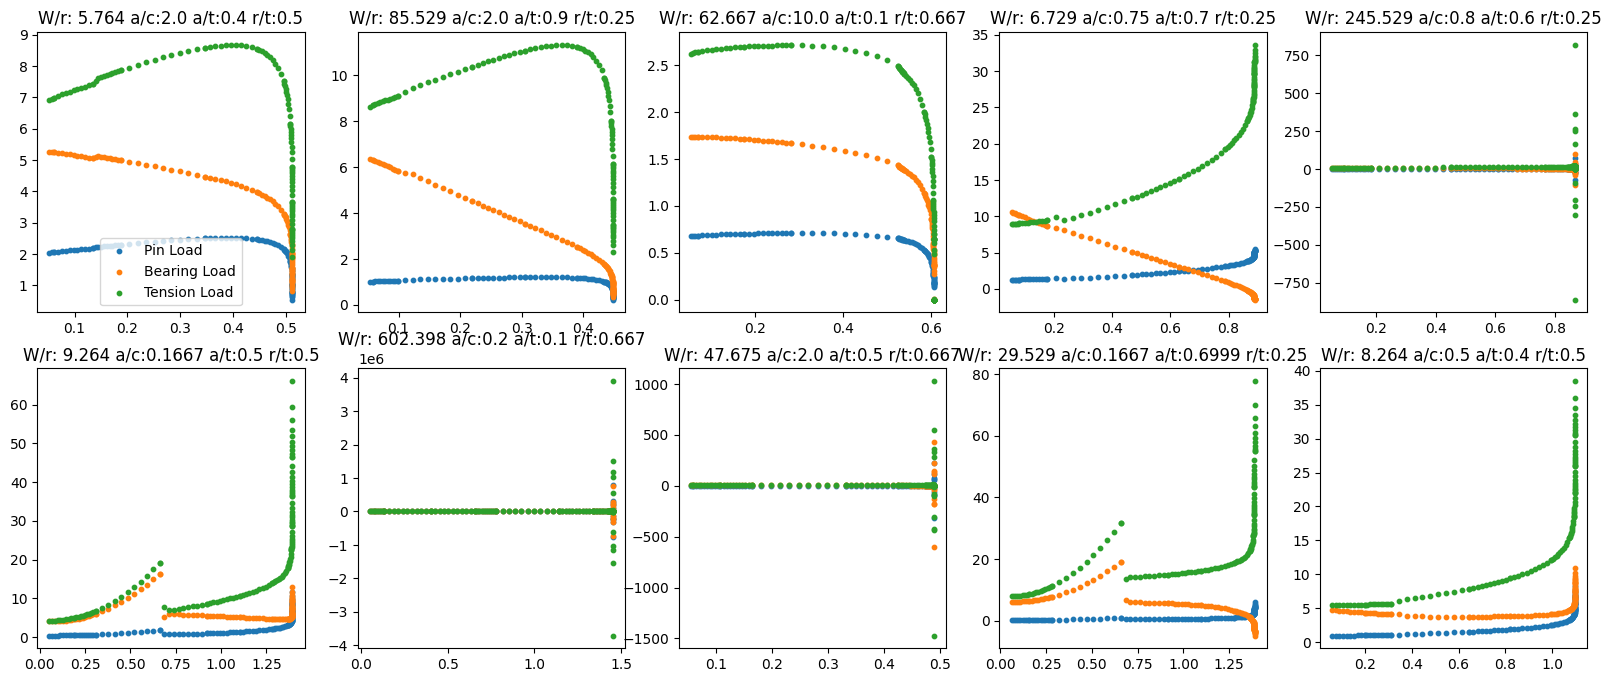

In [14]:
for file in csv_files:
    print("========================")
    print("Working On: {}".format(file))
    print("========================")
    df = pd.read_csv("../files/data/{}/{}".format(master_folder, file))
    d = df.to_numpy()

    # Getting all a/c, a/t and c/b combinations
    CC_combinations = [d[0,:5]]

    for line in d:
        if (line[:5] == CC_combinations[-1]).all():
            continue
        else:
            CC_combinations.append(line[:5])

    CC_combinations = np.unique(CC_combinations, axis=0)

    print("Different combinations: ", len(CC_combinations))
    
    print("")

    print("Different W/r values: ", np.unique(CC_combinations[:,0], axis=0))
    print("Different a/c values: ", np.unique(CC_combinations[:,1], axis=0))
    print("Different a/t values: ", np.unique(CC_combinations[:,2], axis=0))
    print("Different r/t values: ", np.unique(CC_combinations[:,3], axis=0))
    print("Different b/t values: ", np.unique(CC_combinations[:,4], axis=0))

    np.random.seed(0)
    fig, axs = plt.subplots(2, 5, figsize=(20,8))
    for i in range(2):
        for j in range(5):
            idx = np.random.randint(0, len(CC_combinations))
            combination = CC_combinations[idx]
            indices = np.where((d[:, 0] == combination[0]) & 
                            (d[:, 1] == combination[1]) &
                            (d[:, 2] == combination[2]) &
                            (d[:, 3] == combination[3]) &
                            (d[:, -4] >= np.max(np.unique(0.052))) & 
                            (d[:, -4] <= np.min(np.unique(1.52))))
            indices = indices[0]
            axs[i,j].scatter(d[indices][:,-4], d[indices][:,-1], label="Pin Load", s=10)
            axs[i,j].scatter(d[indices][:,-4], d[indices][:,-2], label="Bearing Load", s=10)
            axs[i,j].scatter(d[indices][:,-4], d[indices][:,-3], label="Tension Load", s=10)
            axs[i,j].set_title("W/r: {} a/c:{} a/t:{} r/t:{}".format(combination[0], combination[1], combination[2], combination[3]))
            
            if i == 0 and j == 0:
                axs[i,j].legend()
    plt.show()